In [1]:
# 2018-2022년 전국 아파트 실거래 정보

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import openpyxl
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit

In [2]:
df1 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/complex_20230308 (사본).csv', header=None)
df1.columns = ['old_addr_idx', 'complex_name', 'property_type','시도', '시군구',
               '읍면동','리','road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub','updated']
df1.drop(['road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub', 'updated'], axis=1, inplace=True)

df1['시군구'] = df1['시군구'].str.split().str[0]
df1 = df1[df1['property_type']!='officetel']
df1.drop(['property_type'], axis=1, inplace=True)

In [3]:
df1

,old_addr_idx,complex_name,시도,시군구,읍면동,리
0,1111010100_00001_00000_apartment,청운벽산빌리지,서울특별시,종로구,청운동,NaN
1,1111010100_00003_00000_apartment,인텔빌라B C동,서울특별시,종로구,청운동,NaN
2,1111010100_00003_00150_apartment,인텔빌라A동,서울특별시,종로구,청운동,NaN
3,1111010100_00004_00001_apartment,아델하우스,서울특별시,종로구,청운동,NaN
4,1111010100_00004_00003_apartment,GRACETUSCANII,서울특별시,종로구,청운동,NaN
...,...,...,...,...,...,...
320920,5013032022_00048_00003_apartment,표선제이파크빌,제주특별자치도,서귀포시,표선면,하천리
320921,5013032022_02167_00000_apartment,지오화이트빌리지,제주특별자치도,서귀포시,표선면,하천리
320922,5013032023_02008_00000_apartment,보네르펜션,제주특별자치도,서귀포시,표선면,성읍리
320923,5013032024_02521_00005_apartment,(2521-5),제주특별자치도,서귀포시,표선면,가시리


In [4]:
df2 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/property_20230308.csv', header=None)
df2.columns = ['pk','old_addr_idx','dong','ho','official_price','net_leasable_area','updated']

In [5]:
app_apt = df2.merge(df1, on='old_addr_idx')
pd.options.display.max_columns = None
app_apt['평수'] = app_apt['net_leasable_area'] / 3.3
app_apt.drop(['net_leasable_area'], axis=1, inplace=True)
app_apt.replace('\\N', np.nan, inplace=True)
app_apt['시군구'] = app_apt['시군구'].fillna('세종특별자치시')

In [6]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636
...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394


In [7]:
sido_list = app_apt['시도'].unique().tolist()
sido_list

['서울특별시',
 '부산광역시',
 '인천광역시',
 '경기도',
 '강원도',
 '충청북도',
 '세종특별자치시',
 '대전광역시',
 '충청남도',
 '전라북도',
 '광주광역시',
 '전라남도',
 '대구광역시',
 '경상북도',
 '경상남도',
 '울산광역시',
 '제주특별자치도']

In [8]:
app_apt['호']=app_apt['ho'].astype(str)

In [9]:
app_apt['호int'] = app_apt['호'].apply(lambda x: int(x) if x.isnumeric() else 0)

In [10]:
app_apt['호str'] = app_apt['호'].apply(lambda x: np.nan if x.isnumeric() else 0 if x.isdigit() else x)

In [11]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN


In [12]:
start = 100
step = 100
num_steps = 83
ranges1 = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]
labels1 = [r[2] for r in ranges1]
bins1 = [r[0] for r in ranges1] + [ranges1[-1][1]]

bins = bins1
labels = labels1

app_apt['층'] = pd.cut(app_apt['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

In [13]:
floorSplit = app_apt[app_apt['호str'].str.contains('층')==True]

In [14]:
floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]

<ipython-input-14-5380e5940272>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['호str'] = floorSplit['호str'].str.split('층').str[0]


In [15]:
floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

<ipython-input-15-fe789eedf5cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['호int'] = floorSplit['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)


In [16]:
start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-16-9318b6f1daca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [17]:
start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the '호int' column to a categorical column
floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-17-1196a492ffd3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['층2'] = pd.cut(floorSplit['호int'], bins=bins, labels=labels, include_lowest=True, right=False)


In [18]:
codes = floorSplit['층'].cat.codes
codes2 = floorSplit['층2'].cat.codes
floorSplit['codes'] = codes.reindex(floorSplit.index)
floorSplit['codes2'] = codes2.reindex(floorSplit.index)
floorSplit['codes'].replace(-1, np.nan, inplace=True)
floorSplit['codes2'].replace(-1, np.nan, inplace=True)
floorSplit['codes'] = floorSplit['codes'] + 1
floorSplit['codes2'] = floorSplit['codes2'] + 1
floorSplit['codes'] = floorSplit['codes'].fillna(floorSplit['codes2'])
floorSplit.drop(['층', '층2', 'codes2'], axis=1, inplace=True)

<ipython-input-18-493d9e1025b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes'] = codes.reindex(floorSplit.index)
<ipython-input-18-493d9e1025b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  floorSplit['codes2'] = codes2.reindex(floorSplit.index)
<ipython-input-18-493d9e1025b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [19]:
check = floorSplit[floorSplit['codes'].isnull()==True]

In [20]:
jiha = check[check['호str'].str.contains('지하')==True]
jiha['codes'] = -1
jiha = jiha[['pk', 'codes']]
check = check.merge(jiha, on=['pk'], how='left')
check = check.drop('codes_x', axis=1)
check = check.rename(columns={'codes_y':'codes'})

jisang = check[check['호str'].str.contains('지상')]
jisang['호str'] = jisang['호str'].str.split('지상').str[1]
jisang['codes'] = jisang['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

mask = (jisang['pk']=='11999085_0001_0001')
jisang.loc[mask, 'codes']=1
mask = (jisang['pk']=='12148950_0001_0002')
jisang.loc[mask, 'codes']=2
mask = (jisang['pk']=='12148950_0001_0004')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0005')
jisang.loc[mask, 'codes']=3
mask = (jisang['pk']=='12148950_0001_0006')
jisang.loc[mask, 'codes']=4

jisang = jisang[['pk', 'codes']]

check = check.merge(jisang, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

justJi = check[check['호str'].str.contains('지')&~(check['호str'].str.contains('지하'))&~(check['호str'].str.contains('지상'))]
justJi['codes'] = -1

justJi = justJi[['pk', 'codes']]

check = check.merge(justJi, on=['pk'], how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-20-4e921100afe9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha['codes'] = -1
<ipython-input-20-4e921100afe9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang['호str'] = jisang['호str'].str.split('지상').str[1]
<ipython-input-20-4e921100afe9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [21]:
dong = check[(check['호str'].str.contains('동')==True) & (check['호str'].str.contains('지')!=True)]
dong['호str'] = dong['호str'].str.split('동').str[1]

mask = (dong['호str'].str.contains('3'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('4'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('일'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('이'))
dong.loc[mask, 'codes'] = 2
mask = (dong['호str'].str.contains('삼'))
dong.loc[mask, 'codes'] = 3
mask = (dong['호str'].str.contains('사'))
dong.loc[mask, 'codes'] = 4
mask = (dong['호str'].str.contains('5'))
dong.loc[mask, 'codes'] = 5

mask = (dong['호str'].str.contains('1')) & (~dong['호str'].str.contains('2'))
dong.loc[mask, 'codes'] = 1
mask = (dong['호str'].str.contains('2')) & (~dong['호str'].str.contains('1'))
dong.loc[mask, 'codes'] = 2

mask = (dong['호str']=='10')
dong.loc[mask, 'codes'] = 10
mask = (dong['호str']=='11')
dong.loc[mask, 'codes'] = 11
mask = (dong['호str']=='12')
dong.loc[mask, 'codes'] = 12
mask = (dong['호str']=='13')
dong.loc[mask, 'codes'] = 13
mask = (dong['호str']=='14')
dong.loc[mask, 'codes'] = 14
mask = (dong['호str']=='15')
dong.loc[mask, 'codes'] = 15

mask = (dong['호str']=='2호1')
dong.loc[mask, 'codes'] = 1
mask = (dong['호str']=='1호2')
dong.loc[mask, 'codes'] = 2

dong = dong[['pk', 'codes']]

check = check.merge(dong, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

<ipython-input-21-9432fbcc790e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dong['호str'] = dong['호str'].str.split('동').str[1]


In [22]:
rest = check[check['codes'].isnull()==True]

regex = r'\D+(\d+)$'
rest['codes'] = rest['호str'].str.extract(regex)

rest_of_rest = rest[rest['codes'].isnull()==True]

mask = (rest_of_rest['호str'].str.contains('일'))
rest_of_rest.loc[mask, 'codes'] = 1
mask = (rest_of_rest['호str'].str.contains('이'))
rest_of_rest.loc[mask, 'codes'] = 2
mask = (rest_of_rest['호str'].str.contains('사'))
rest_of_rest.loc[mask, 'codes'] = 4
mask = (rest_of_rest['호str'].str.contains('삼'))
rest_of_rest.loc[mask, 'codes'] = 3
mask = (rest_of_rest['호str'].str.contains('오'))
rest_of_rest.loc[mask, 'codes'] = 5
mask = (rest_of_rest['호str'].str.contains('육'))
rest_of_rest.loc[mask, 'codes'] = 6
mask = (rest_of_rest['호str'].str.contains('칠'))
rest_of_rest.loc[mask, 'codes'] = 7

rest_of_rest_bok = rest_of_rest[rest_of_rest['codes'].isnull()==True]
rest_of_rest_bok = rest_of_rest[rest_of_rest['호str'].str.contains('복')]
rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]

rest_of_rest_bok['numeric'] = rest_of_rest_bok['호str'].str.extract('(\d+)')
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].fillna(0)
rest_of_rest_bok['numeric'] = rest_of_rest_bok['numeric'].astype(int)

start = 100
step = 100
num_steps = 16
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

rest_of_rest_bok['층'] = pd.cut(rest_of_rest_bok['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)



<ipython-input-22-3e2152d64c0e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest['codes'] = rest['호str'].str.extract(regex)
<ipython-input-22-3e2152d64c0e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['호str']= rest_of_rest_bok['호str'].str.split('복').str[0]
<ipython-input-22-3e2152d64c0e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [23]:
codes3 = rest_of_rest_bok['층'].cat.codes
rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
rest_of_rest_bok['codes3'] = rest_of_rest_bok['codes3'] + 1
rest_of_rest_bok.drop(['codes', 'numeric', '층'], axis=1, inplace=True)
rest_of_rest_bok = rest_of_rest_bok.rename(columns={'codes3':'codes'})
rest_of_rest_bok = rest_of_rest_bok[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_bok, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

mask = (rest_of_rest['codes']==0)
rest_of_rest.loc[mask, 'codes'] = 3

<ipython-input-23-1b9d5dade8fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'] = codes3.reindex(rest_of_rest_bok.index)
<ipython-input-23-1b9d5dade8fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_rest_bok['codes3'].replace(-1, np.nan, inplace=True)
<ipython-input-23-1b9d5dade8fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [24]:
rest_of_rest_ = rest_of_rest[rest_of_rest['codes'].isnull()==True]

mask = (rest_of_rest_['ho'].str.contains('별층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('비층'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('B'))
rest_of_rest_.loc[mask, 'codes'] = -1
mask = (rest_of_rest_['ho'].str.contains('401'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('402'))
rest_of_rest_.loc[mask, 'codes'] = 4
mask = (rest_of_rest_['ho'].str.contains('201'))
rest_of_rest_.loc[mask, 'codes'] = 2
mask = (rest_of_rest_['ho'].str.contains('202'))
rest_of_rest_.loc[mask, 'codes'] = 2

mask = (rest_of_rest_['pk']=='12085035_0001_0004')
rest_of_rest_.loc[mask, 'codes'] = 4

rest_of_rest_ = rest_of_rest_[['pk', 'codes']]

rest_of_rest = rest_of_rest.merge(rest_of_rest_, on='pk', how='left')
rest_of_rest['codes_x'] = rest_of_rest['codes_x'].fillna(rest_of_rest['codes_y'])
rest_of_rest = rest_of_rest.rename(columns={'codes_x':'codes'})
rest_of_rest.drop('codes_y', axis=1, inplace=True)

rest_of_rest = rest_of_rest[['pk', 'codes']]
rest = rest.merge(rest_of_rest, on='pk', how='left')
rest['codes_x'] = rest['codes_x'].fillna(rest['codes_y'])
rest = rest.rename(columns={'codes_x':'codes'})
rest.drop('codes_y', axis=1, inplace=True)

rest = rest[['pk', 'codes']]
check = check.merge(rest, on='pk', how='left')
check['codes_x'] = check['codes_x'].fillna(check['codes_y'])
check = check.rename(columns={'codes_x':'codes'})
check.drop('codes_y', axis=1, inplace=True)

check = check[['pk', 'codes']]
floorSplit = floorSplit.merge(check, on='pk', how='left')
floorSplit['codes_x'] = floorSplit['codes_x'].fillna(floorSplit['codes_y'])
floorSplit = floorSplit.rename(columns={'codes_x':'codes'})
floorSplit.drop('codes_y', axis=1, inplace=True)

mask = (floorSplit['pk']=='12030365_0001_0005')
floorSplit.loc[mask, 'codes'] = 3
mask = (floorSplit['pk']=='12035834_0001_0003')
floorSplit.loc[mask, 'codes'] = 3

In [25]:
codes4 = app_apt['층'].cat.codes
app_apt['codes'] = codes4.reindex(app_apt.index)
app_apt['codes'] = app_apt['codes'] + 1
app_apt['codes'].replace(0, np.nan, inplace=True)

floorSplit = floorSplit[['pk', 'codes']]
app_apt = app_apt.merge(floorSplit, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [26]:
last = app_apt[app_apt['codes'].isnull()==True]
last.drop(['호int', '호str', '층'], axis=1, inplace=True)

<ipython-input-26-a88709004904>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last.drop(['호int', '호str', '층'], axis=1, inplace=True)


In [27]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 6 to 14495298
Series name: codes
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 3.5+ MB


In [28]:
jiha2 = last[last['호'].str.contains('지하')==True]
jiha2['codes'] = -1
jiha2 = jiha2[['pk', 'codes']]
last = last.merge(jiha2, on=['pk'], how='left')
last = last.drop('codes_x', axis=1)
last = last.rename(columns={'codes_y':'codes'})

<ipython-input-28-c4a92d2f4a90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jiha2['codes'] = -1


In [29]:
jisang2 = last[last['호'].str.contains('지상')]
jisang2['호'] = jisang2['호'].str.split('지상').str[1]

<ipython-input-29-25076aa31f93>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['호'] = jisang2['호'].str.split('지상').str[1]


In [30]:
jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
jisang2['numeric'] = jisang2['numeric'].fillna(0)
jisang2['numeric'] = jisang2['numeric'].astype(int)

start = 100
step = 100
num_steps = 18
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

jisang2['층'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

start1 = 1
step1 = 1
num_steps1 = 90
ranges2 = [(start1 + step1 * i, start1 + step1 * i + 0.1, i+1) for i in range(num_steps1)]
labels2 = [r[2] for r in ranges2]
bins2 = [r[0] for r in ranges2] + [ranges2[-1][1]]

# concatenate the two lists of bin edges and labels
bins = bins2
labels = labels2
# convert the 'numeric' column to a categorical column
jisang2['층2'] = pd.cut(jisang2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

codes = jisang2['층'].cat.codes
codes2 = jisang2['층2'].cat.codes
jisang2['codes'] = codes.reindex(jisang2.index)
jisang2['codes2'] = codes2.reindex(jisang2.index)
jisang2['codes'].replace(-1, np.nan, inplace=True)
jisang2['codes2'].replace(-1, np.nan, inplace=True)
jisang2['codes'] = jisang2['codes'] + 1
jisang2['codes2'] = jisang2['codes2'] + 1
jisang2['codes'] = jisang2['codes'].fillna(jisang2['codes2'])
jisang2.drop(['층', '층2', 'codes2', 'numeric'], axis=1, inplace=True)

mask = (jisang2['pk']=='20031264_0001_0001')
jisang2.loc[mask, 'codes'] = 1

<ipython-input-30-4e5c74641632>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['호'].str.extract('(\d+)')
<ipython-input-30-4e5c74641632>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jisang2['numeric'] = jisang2['numeric'].fillna(0)
<ipython-input-30-4e5c74641632>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [31]:
last

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,codes
0,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,NaN
1,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,NaN
2,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,NaN
3,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,NaN
4,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230832,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,NaN
230833,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,NaN
230834,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,NaN
230835,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,NaN


In [32]:
jisang2 = jisang2[['pk', 'codes']]
last = last.merge(jisang2, on='pk', how='left')
last['codes_x'] = last['codes_x'].fillna(last['codes_y'])
last = last.rename(columns={'codes_x':'codes'})
last.drop('codes_y', axis=1, inplace=True)

In [33]:
last['codes'].info()

<class 'pandas.core.series.Series'>
Int64Index: 230837 entries, 0 to 230836
Series name: codes
Non-Null Count  Dtype  
--------------  -----  
9511 non-null   float64
dtypes: float64(1)
memory usage: 3.5 MB


In [34]:
last = last[['pk', 'codes']]
last = last.dropna(subset='codes')
app_apt = app_apt.merge(last, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [36]:
###########################################                                         ###################################
##############################################    공시지가 층수 작업 미완료 !!!    #############################################
###########################################       공시지가 층수 작업 미완료 !!!      #######################################
#########################################                                           ###############################################

pd.set_option('display.max_rows', 10)

In [37]:
last2 = app_apt[app_apt['codes'].isnull()==True]

In [38]:
last2['numeric'] = last2['호'].str.extract('(\d+)')
last2['numeric'] = last2['numeric'].fillna(0)
last2['numeric'] = last2['numeric'].astype(int)

start = 100
step = 100
num_steps = 50
ranges = [(start + step * i, start + step * i + 10, i+1) for i in range(num_steps)]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

last2['층'] = pd.cut(last2['numeric'], bins=bins, labels=labels, include_lowest=True, right=False)

<ipython-input-38-7494bad5c2f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['호'].str.extract('(\d+)')
<ipython-input-38-7494bad5c2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['numeric'] = last2['numeric'].fillna(0)
<ipython-input-38-7494bad5c2f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [39]:
mask = (last2['numeric']==0)
last2.loc[mask, 'numeric'] = 1

In [40]:
mask = (last2['호'].str.contains('B0'))
last2.loc[mask, 'numeric'] = -1

In [41]:
codes5 = last2['층'].cat.codes
last2['codes2'] = codes.reindex(last2.index)
last2['codes2'].replace(-1, np.nan, inplace=True)
last2['codes2'] = last2['codes2'] + 1
last2['codes'] = last2['codes'].fillna(last2['codes2'])
last2['codes'] = last2['codes'].fillna(last2['numeric'])
last2.drop(['층','codes2', 'numeric'], axis=1, inplace=True)

<ipython-input-41-924028124f2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'] = codes.reindex(last2.index)
<ipython-input-41-924028124f2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last2['codes2'].replace(-1, np.nan, inplace=True)
<ipython-input-41-924028124f2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [42]:
last2

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,codes
6,00000001_0001_0007,1111010100_00004_00007_apartment,단일,B02,390000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,27.490909,B02,0,B02,-1.0
7,00000001_0001_0008,1111010100_00004_00007_apartment,단일,B01,524000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,35.990909,B01,0,B01,-1.0
8,00000002_0001_0001,1111010100_00003_00000_apartment,비,1,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.927273,1,1,NaN,1.0
9,00000002_0001_0002,1111010100_00003_00000_apartment,비,10,1391000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.745455,10,10,NaN,10.0
10,00000002_0001_0003,1111010100_00003_00000_apartment,비,2,1382000000,2021-01-01,인텔빌라B C동,서울특별시,종로구,청운동,NaN,70.800000,2,2,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14482716,20430554_0002_0019,4146125321_00531_00005_apartment,102,B03,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B03,0,B03,-1.0
14482717,20430554_0002_0020,4146125321_00531_00005_apartment,102,B04,254000000,2021-12-01,모드니타운,경기도,용인시,모현읍,왕산리,25.283909,B04,0,B04,-1.0
14493054,20431047_0001_0009,4161025322_00277_00007_apartment,101,B02,216000000,2021-10-01,T.S크라이시Ⅲ,경기도,광주시,초월읍,쌍동리,25.374242,B02,0,B02,-1.0
14495297,20431216_0001_0001,4122025042_00088_00000_apartment,A,A,573000000,2021-06-01,WoodenBreeze,경기도,평택시,팽성읍,동창리,82.887879,A,0,A,1.0


In [43]:
last2 = last2[['pk', 'codes']]
app_apt = app_apt.merge(last2, on='pk', how='left')
app_apt['codes_x'] = app_apt['codes_x'].fillna(app_apt['codes_y'])
app_apt = app_apt.rename(columns={'codes_x':'codes'})
app_apt.drop('codes_y', axis=1, inplace=True)

In [44]:
app_apt

,pk,old_addr_idx,dong,ho,official_price,updated,complex_name,시도,시군구,읍면동,리,평수,호,호int,호str,층,codes
0,00000001_0001_0001,1111010100_00004_00007_apartment,단일,101,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.978788,101,101,NaN,1,1.0
1,00000001_0001_0002,1111010100_00004_00007_apartment,단일,102,1076000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,63.396970,102,102,NaN,1,1.0
2,00000001_0001_0003,1111010100_00004_00007_apartment,단일,201,1140000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,62.996970,201,201,NaN,2,2.0
3,00000001_0001_0004,1111010100_00004_00007_apartment,단일,202,1249000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,65.178788,202,202,NaN,2,2.0
4,00000001_0001_0005,1111010100_00004_00007_apartment,단일,301,1332000000,2021-01-01,신구파인힐,서울특별시,종로구,청운동,NaN,66.463636,301,301,NaN,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14496524,20432545_0001_0012,2647010200_01288_00036_apartment,A,404,43100000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,404,404,NaN,4,4.0
14496525,20432545_0001_0013,2647010200_01288_00036_apartment,A,502,43300000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.630303,502,502,NaN,5,5.0
14496526,20432545_0001_0014,2647010200_01288_00036_apartment,A,504,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,504,504,NaN,5,5.0
14496527,20432545_0001_0015,2647010200_01288_00036_apartment,A,501,42400000,2022-01-01,더페이스(A동),부산광역시,연제구,연산동,NaN,5.539394,501,501,NaN,5,5.0


In [45]:
app_apt_match = app_apt[['old_addr_idx', 'official_price', '시도', '시군구', '읍면동', '리', '평수', 'codes']]
app_apt_match = app_apt_match.rename(columns={'codes':'층수', 'official_price':'공시지가'})
app_apt_match = app_apt_match.drop_duplicates()

In [46]:
app_apt_match

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
0,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,63.978788,1.0
1,1111010100_00004_00007_apartment,1076000000,서울특별시,종로구,청운동,NaN,63.396970,1.0
2,1111010100_00004_00007_apartment,1140000000,서울특별시,종로구,청운동,NaN,62.996970,2.0
3,1111010100_00004_00007_apartment,1249000000,서울특별시,종로구,청운동,NaN,65.178788,2.0
4,1111010100_00004_00007_apartment,1332000000,서울특별시,종로구,청운동,NaN,66.463636,3.0
...,...,...,...,...,...,...,...,...
14496518,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,3.0
14496521,2647010200_01288_00036_apartment,43900000,부산광역시,연제구,연산동,NaN,5.630303,4.0
14496523,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,4.0
14496525,2647010200_01288_00036_apartment,43300000,부산광역시,연제구,연산동,NaN,5.630303,5.0


In [47]:
daegu = app_apt_match[app_apt_match['시도']=='부산광역시']

In [48]:
daegu

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수
857506,2611010700_00040_00015_apartment,34500000,부산광역시,중구,중앙동4가,NaN,18.333333,-1.0
857507,2611010700_00040_00015_apartment,34500000,부산광역시,중구,중앙동4가,NaN,18.230303,-1.0
857508,2611010700_00040_00015_apartment,33000000,부산광역시,중구,중앙동4가,NaN,18.030303,-1.0
857509,2611010700_00040_00015_apartment,33000000,부산광역시,중구,중앙동4가,NaN,17.930303,-1.0
857510,2611010700_00040_00015_apartment,56600000,부산광역시,중구,중앙동4가,NaN,18.230303,1.0
...,...,...,...,...,...,...,...,...
14496518,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,3.0
14496521,2647010200_01288_00036_apartment,43900000,부산광역시,연제구,연산동,NaN,5.630303,4.0
14496523,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,4.0
14496525,2647010200_01288_00036_apartment,43300000,부산광역시,연제구,연산동,NaN,5.630303,5.0


In [49]:
areaCode = pd.read_excel('/home/subin/다운로드/행정_법정동 중심좌표_동별.xlsx')
areaCode = areaCode[areaCode['코드종류']=='B']
areaCode.drop(['코드', '코드종류'], axis=1, inplace=True)
areaCode['시군구'] = areaCode['시군구'].str.split().str[0]

In [50]:
areaCodeMain = areaCode[areaCode['시도']=='부산광역시']

In [51]:
areaCodeMain

,시도,시군구,읍면동,리,위도,경도
4013,부산광역시,중구,영주동,NaN,35.111289,129.033343
4014,부산광역시,중구,대창동1가,NaN,35.108223,129.036259
4015,부산광역시,중구,대창동2가,NaN,35.110773,129.037375
4016,부산광역시,중구,중앙동1가,NaN,35.100730,129.035737
4017,부산광역시,중구,중앙동2가,NaN,35.102058,129.035460
...,...,...,...,...,...,...
4255,부산광역시,기장군,철마면,구칠리,35.260885,129.170258
4256,부산광역시,기장군,철마면,이곡리,35.274088,129.180461
4257,부산광역시,기장군,철마면,고촌리,35.241346,129.167294
4258,부산광역시,기장군,철마면,안평리,35.238032,129.177674


In [52]:
daegu =daegu.merge(areaCodeMain, on=['시도', '시군구', '읍면동', '리'], how='left')

In [53]:
daegu

,old_addr_idx,공시지가,시도,시군구,읍면동,리,평수,층수,위도,경도
0,2611010700_00040_00015_apartment,34500000,부산광역시,중구,중앙동4가,NaN,18.333333,-1.0,35.106708,129.036583
1,2611010700_00040_00015_apartment,34500000,부산광역시,중구,중앙동4가,NaN,18.230303,-1.0,35.106708,129.036583
2,2611010700_00040_00015_apartment,33000000,부산광역시,중구,중앙동4가,NaN,18.030303,-1.0,35.106708,129.036583
3,2611010700_00040_00015_apartment,33000000,부산광역시,중구,중앙동4가,NaN,17.930303,-1.0,35.106708,129.036583
4,2611010700_00040_00015_apartment,56600000,부산광역시,중구,중앙동4가,NaN,18.230303,1.0,35.106708,129.036583
...,...,...,...,...,...,...,...,...,...,...
390260,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,3.0,35.180963,129.090641
390261,2647010200_01288_00036_apartment,43900000,부산광역시,연제구,연산동,NaN,5.630303,4.0,35.180963,129.090641
390262,2647010200_01288_00036_apartment,43100000,부산광역시,연제구,연산동,NaN,5.539394,4.0,35.180963,129.090641
390263,2647010200_01288_00036_apartment,43300000,부산광역시,연제구,연산동,NaN,5.630303,5.0,35.180963,129.090641


In [54]:
code = areaCode[areaCode['시도']=='부산광역시'].groupby(['시도','시군구']).mean().reset_index()
code['읍면동'] = np.nan
daegu = code.set_index(['시도', '시군구', '읍면동']).combine_first(daegu.set_index(['시도', '시군구', '읍면동'])).reset_index()

<ipython-input-54-1fa86598b6db>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']=='부산광역시'].groupby(['시도','시군구']).mean().reset_index()


In [55]:
daegu

,시도,시군구,읍면동,old_addr_idx,경도,공시지가,리,위도,층수,평수
0,부산광역시,강서구,강동동,2644010300_00029_00320_apartment,128.924950,79300000,NaN,35.191611,2.0,15.842424
1,부산광역시,강서구,강동동,2644010300_00029_00320_apartment,128.924950,79300000,NaN,35.191611,3.0,15.842424
2,부산광역시,강서구,강동동,2644010300_00029_00320_apartment,128.924950,76100000,NaN,35.191611,4.0,15.842424
3,부산광역시,강서구,녹산동,2644011100_00546_00017_apartment,128.885476,143000000,NaN,35.115798,2.0,19.027273
4,부산광역시,강서구,녹산동,2644011100_00546_00017_apartment,128.885476,142000000,NaN,35.115798,2.0,18.848485
...,...,...,...,...,...,...,...,...,...,...
390260,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,257000000,NaN,35.190559,15.0,12.119909
390261,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,312000000,NaN,35.190559,16.0,14.969212
390262,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,257000000,NaN,35.190559,16.0,12.119909
390263,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,312000000,NaN,35.190559,17.0,14.969212


In [56]:
daegu_name = daegu[['old_addr_idx', '위도', '경도']]
daegu_name = daegu_name.drop_duplicates()
daegu_name['위도+경도'] = daegu_name['위도'].astype(str) + daegu_name['경도'].astype(str)

In [57]:
daeguArea = daegu[['위도', '경도']]
daeguArea = daeguArea.drop_duplicates()
daeguArea['위도+경도'] = daeguArea['위도'].astype(str) + daeguArea['경도'].astype(str)

In [58]:
school = pd.read_excel('/home/subin/다운로드/전국초중등학교위치표준데이터-20230404.xls')
school.rename(columns=school.iloc[0], inplace=True)
school = school.drop(0)

school['시도']=school['시도교육청명'].str.split('교육청').str[0]
school.drop(['시도교육청명', '제공기관명', '생성일자', '변경일자', '교육지원청명', '데이터기준일자','소재지지번주소', '소재지도로명주소', '설립일자',
             '학교ID', '제공기관코드', '시도교육청코드', '교육지원청코드', '운영상태'], axis=1, inplace=True)
school['학교급구분'] = school['학교급구분'].str.split('학교').str[0]

school['위도'] = school['위도'].astype(float).round(6)
school['경도'] = school['경도'].astype(float).round(6)

In [59]:
school_daegu = school[school['시도']=='부산광역시']
school_daegu

,학교명,학교급구분,설립형태,본교분교구분,위도,경도,시도
3,명문초등학교,초등,공립,본교,35.099814,128.913581,부산광역시
28,태종대중학교,중,공립,본교,35.073674,129.064920,부산광역시
29,혜화초등학교,초등,사립,본교,35.202260,129.113294,부산광역시
30,연신초등학교,초등,공립,본교,35.192482,129.093160,부산광역시
44,센텀고등학교,고등,공립,본교,35.177103,129.126981,부산광역시
...,...,...,...,...,...,...,...
11946,한국과학영재학교,고등,국립,본교,35.165200,129.025784,부산광역시
11949,서감초등학교,초등,공립,본교,35.157820,128.982060,부산광역시
11968,부일외국어고등학교,고등,사립,본교,35.090736,129.002560,부산광역시
11970,삼성여자고등학교,고등,사립,본교,35.094225,128.998233,부산광역시


In [60]:
school_ele = school_daegu[school_daegu['학교급구분']=='초등']
school_mid = school_daegu[school_daegu['학교급구분']=='중']
school_high = school_daegu[school_daegu['학교급구분']=='고등']

In [61]:
school_daeguArea= school_daegu.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_eleArea = school_ele.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_midArea = school_mid.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_highArea = school_high.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)

In [62]:
daegu_subway = pd.read_csv('/home/subin/다운로드/busan_subway.csv')
daegu_subway = daegu_subway.rename(columns={'역위도': '위도', '역경도': '경도'})
daegu_subway.drop('Unnamed: 0', '위경도', axis=1, inplace=True)
daegu_subway

,Unnamed: 0,역사명,노선명,위도,경도
0,0,다대포해수욕장,부산도시철도 1호선,35.048670,128.964100
1,1,다대포항역,부산도시철도 1호선,35.057820,128.971300
2,2,낫개역,부산도시철도 1호선,35.065265,128.979873
3,3,신장림역,부산도시철도 1호선,35.074433,128.977041
4,4,장림역,부산도시철도 1호선,35.081090,128.977500
...,...,...,...,...,...
109,109,석대역,부산도시철도 4호선,35.218112,129.137179
110,110,영산대역,부산도시철도 4호선,35.225777,129.146149
111,111,윗반송역,부산도시철도 4호선,35.232506,129.154024
112,112,고촌역,부산도시철도 4호선,35.236031,129.160444


In [64]:
from scipy.spatial.distance import cdist
housing_coords = daeguArea[['위도', '경도']].values
subway_coords = daegu_subway[['위도', '경도']].values
distances_matrix = cdist(housing_coords, subway_coords, metric=haversine)
distances_df = pd.DataFrame(distances_matrix, columns=daegu_subway['역사명'], index=daeguArea['위도+경도'])
distances_df = distances_df.reset_index().melt(id_vars='위도+경도', var_name='subway_id', value_name='distance')

In [65]:
distances_df.groupby(['위도+경도', 'subway_id']).min().reset_index().describe()

,distance
count,22572.000000
mean,12.632129
std,7.340026
min,0.021489
25%,7.040405
50%,11.591276
75%,16.886452
max,45.204343


In [66]:
dis_df_46km = distances_df[distances_df['distance']<46]
daegu_subway_46km = daegu_name.merge(dis_df_46km, on='위도+경도')
daegu_subway_46km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [67]:
daegu_subway_1km =daegu_subway_46km[daegu_subway_46km['distance']<=1]
daegu_subway = pd.merge(daegu_name, daegu_subway_1km, how='left', on='old_addr_idx')
value_counts = daegu_subway[daegu_subway['distance']<=1]['old_addr_idx'].value_counts()
daegu['1km내sub수'] = daegu['old_addr_idx'].map(value_counts)
daegu['1km내sub수'] = daegu['1km내sub수'].fillna(0)

In [68]:
closest_subway_dis =daegu_subway_46km.groupby('old_addr_idx').min().drop('subway_id', axis=1).reset_index()
daegu = daegu.merge(closest_subway_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_sub'})

In [69]:
housing_coords = daeguArea[['위도', '경도']].values
school_coords = school_daegu[['위도', '경도']].values
distances_matrix2 = cdist(housing_coords, school_coords, metric=haversine)
distances_df2 = pd.DataFrame(distances_matrix2, columns=school_daegu['학교명'], index=daeguArea['위도+경도'])
distances_df2 = distances_df2.reset_index().melt(id_vars='위도+경도', var_name='school_id', value_name='distance')

In [71]:
distances_df2.groupby(['위도+경도', 'school_id']).min().reset_index().describe()

,distance
count,121968.000000
mean,12.892019
std,7.956119
min,0.041483
25%,6.978852
50%,11.502267
75%,17.033461
max,54.198397


In [72]:
dis_df2_25km = distances_df2[distances_df2['distance']<25]
#dis_df2_25
#km['school_id'] = dis_df2_25
#km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
#dis_df2_25
#km['school_id'] = dis_df2_25
#km['school_id'].replace('동성고등공민학교', '동성공민고등학교')

In [73]:
dis_ele_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('초등학교')]
dis_mid_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('중학교')]
dis_high_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('고등학교')]

In [74]:
daegu_high_25km = daegu_name.merge(dis_high_25km.drop('school_id', axis=1), on='위도+경도')
closest_high_dis = daegu_high_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [75]:
daegu = daegu.merge(closest_high_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_high'})

In [76]:
daegu_mid_25km = daegu_name.merge(dis_mid_25km.drop('school_id', axis=1), on='위도+경도')
closest_mid_dis = daegu_mid_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [77]:
daegu = daegu.merge(closest_mid_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_mid'})

In [78]:
daegu_ele_25km = daegu_name.merge(dis_ele_25km.drop('school_id', axis=1), on='위도+경도')
closest_ele_dis = daegu_ele_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [79]:
daegu = daegu.merge(closest_ele_dis, how='left', on='old_addr_idx')
daegu = daegu.rename(columns={'distance': 'closest_ele'})

In [80]:
dis_school_3km = dis_df2_25km[dis_df2_25km['distance']<3]

In [81]:
daegu_school_3km = daegu_name.merge(dis_school_3km.drop('school_id', axis=1), on='위도+경도')

In [82]:
daegu_school_1km =daegu_school_3km[daegu_school_3km['distance']<=1]
daegu_school = pd.merge(daegu_name, daegu_school_1km, how='left', on='old_addr_idx')
value_counts2 = daegu_school[daegu_school['distance']<=1]['old_addr_idx'].value_counts()
daegu['school_1km'] = daegu['old_addr_idx'].map(value_counts2)
daegu['school_1km'] = daegu['school_1km'].fillna(0)

In [85]:
pd.set_option('display.max_rows', 10)
daegu.isnull().sum()

시도                 0
시군구                0
읍면동             9513
old_addr_idx       0
경도                 0
                ... 
closest_sub        0
closest_high       0
closest_mid        0
closest_ele        0
school_1km         0
Length: 16, dtype: int64

In [86]:
daegu['평수'] = daegu['평수'].astype(float).round(0)
daegu['층수'] = daegu['층수'].astype(int)

In [87]:
daegu

,시도,시군구,읍면동,old_addr_idx,경도,공시지가,리,위도,층수,평수,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
0,부산광역시,강서구,강동동,2644010300_00029_00320_apartment,128.924950,79300000,NaN,35.191611,2,16.0,0.0,4.076822,1.924434,3.247441,2.748229,0.0
1,부산광역시,강서구,강동동,2644010300_00029_00320_apartment,128.924950,79300000,NaN,35.191611,3,16.0,0.0,4.076822,1.924434,3.247441,2.748229,0.0
2,부산광역시,강서구,강동동,2644010300_00029_00320_apartment,128.924950,76100000,NaN,35.191611,4,16.0,0.0,4.076822,1.924434,3.247441,2.748229,0.0
3,부산광역시,강서구,녹산동,2644011100_00546_00017_apartment,128.885476,143000000,NaN,35.115798,2,19.0,0.0,7.205129,3.380085,0.340957,0.134975,2.0
4,부산광역시,강서구,녹산동,2644011100_00546_00017_apartment,128.885476,142000000,NaN,35.115798,2,19.0,0.0,7.205129,3.380085,0.340957,0.134975,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390260,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,257000000,NaN,35.190559,15,12.0,0.0,2.813902,2.008030,1.990812,2.062894,0.0
390261,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,312000000,NaN,35.190559,16,15.0,0.0,2.813902,2.008030,1.990812,2.062894,0.0
390262,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,257000000,NaN,35.190559,16,12.0,0.0,2.813902,2.008030,1.990812,2.062894,0.0
390263,부산광역시,해운대구,NaN,2635010400_01355_00000_apartment,129.154832,312000000,NaN,35.190559,17,15.0,0.0,2.813902,2.008030,1.990812,2.062894,0.0


In [85]:
###########################################      실거래가         ############################################################

In [88]:
df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)
df3.columns = ['old_addr_idx', '거래날짜', '거래가격', '면적', '층수', '모름', '거래방식', '모름2', '모름3', '시군구', '주소', '읍면동', 'complex_name', '모름4', '모름5', 'property_type']
df3 = df3.drop_duplicates() 
df3['평수'] = df3['면적']/3.3
df3.fillna("NONE", inplace=True)
df3 = df3[~df3['property_type'].str.contains('officetel')]
df3 = df3[['old_addr_idx', '거래가격', '평수', '층수']]
df3

<ipython-input-88-b5dea2fc0aa1>:1: DtypeWarning: Columns (5,6,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv', header=None)


,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,17.890909,2
1,3023010200_00027_00007_apartment,70000000,17.048485,5
2,3023010200_00027_00007_apartment,66000000,17.048485,1
3,3023010200_00027_00007_apartment,77000000,17.048485,3
4,3023010200_00027_00007_apartment,70000000,17.048485,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.436970,5
2203364,5011010400_00777_00000_apartment,580000000,12.027273,4
2203365,5013010400_02161_00000_apartment,317000000,25.704212,2
2203366,5013010500_00147_00000_apartment,214000000,12.027273,1


In [89]:
df3 = df3.drop_duplicates()
df3['평수'] = df3['평수'].astype(float).round(0)

<ipython-input-89-695803c55b6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['평수'] = df3['평수'].astype(float).round(0)


In [90]:
df3

,old_addr_idx,거래가격,평수,층수
0,3023010200_00034_00000_apartment,99000000,18.0,2
1,3023010200_00027_00007_apartment,70000000,17.0,5
2,3023010200_00027_00007_apartment,66000000,17.0,1
3,3023010200_00027_00007_apartment,77000000,17.0,3
5,3023010200_00027_00007_apartment,97500000,17.0,5
...,...,...,...,...
2203363,5011010400_01034_00001_apartment,280000000,25.0,5
2203364,5011010400_00777_00000_apartment,580000000,12.0,4
2203365,5013010400_02161_00000_apartment,317000000,26.0,2
2203366,5013010500_00147_00000_apartment,214000000,12.0,1


In [89]:
# 지하층이 있는 경우는 한 곳 밖에 없음. 
# 따라서 공시지가 층수 나눌 때 지하는 무시해도 됨. 
# (지하층은 모두 오피스텔에서 발생, 오피스텔은 주소 등 다른 결측치가 너무 많음. 뿐만 아니라 공시지가 데이터에서도 애초에 오피스텔은 제외했었음.)

In [90]:
# 실거래가 자료에서는 공시지가와 매핑할 수 있는 게 면적, 층수밖에 없으므로 우선은 이걸 최대한 맞춰보고

# 맵핑이 상당히 까다로울 것으로 예상되는 바, old_addr_idx에 따라 공시지가 평균을 내서 일괄적으로 넣어보기.

# 면적은 맞는데 층수가 틀린 경우 (아마 얘가 많지 않을까)

In [91]:
real_trainInfo = df3.merge(daegu, on=['old_addr_idx', '평수', '층수'], how='left')
real_trainInfo = real_trainInfo.dropna(subset='공시지가')

In [92]:
real_trainInfo.drop(['old_addr_idx','읍면동',  '리'], axis=1, inplace=True)

In [93]:
real_trainInfo

,거래가격,평수,층수,시도,시군구,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
1843165,220000000,22.0,10,부산광역시,강서구,128.885476,147000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843166,185000000,19.0,4,부산광역시,강서구,128.885476,130000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843167,205000000,22.0,4,부산광역시,강서구,128.885476,144000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843168,220000000,22.0,5,부산광역시,강서구,128.885476,145000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843169,225000000,22.0,5,부산광역시,강서구,128.885476,145000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163654,268000000,24.0,14,부산광역시,기장군,129.213080,174000000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2163655,127500000,15.0,4,부산광역시,기장군,129.213080,86100000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2163656,205000000,24.0,2,부산광역시,기장군,129.213080,126000000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2164289,255000000,22.0,20,부산광역시,금정구,129.087089,167000000.0,35.276306,1.0,0.619838,0.920585,0.830803,0.576058,5.0


In [94]:
main_withPrice = real_trainInfo.drop(['시도', '시군구'], axis=1)
main_withoutPrice = real_trainInfo.drop(['거래가격', '시도', '시군구'], axis=1)

In [95]:
main_withPrice

,거래가격,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
1843165,220000000,22.0,10,128.885476,147000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843166,185000000,19.0,4,128.885476,130000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843167,205000000,22.0,4,128.885476,144000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843168,220000000,22.0,5,128.885476,145000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843169,225000000,22.0,5,128.885476,145000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2163654,268000000,24.0,14,129.213080,174000000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2163655,127500000,15.0,4,129.213080,86100000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2163656,205000000,24.0,2,129.213080,126000000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2164289,255000000,22.0,20,129.087089,167000000.0,35.276306,1.0,0.619838,0.920585,0.830803,0.576058,5.0


In [96]:
main_withoutPrice

,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km
1843165,22.0,10,128.885476,147000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843166,19.0,4,128.885476,130000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843167,22.0,4,128.885476,144000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843168,22.0,5,128.885476,145000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
1843169,22.0,5,128.885476,145000000.0,35.115798,0.0,7.205129,3.380085,0.340957,0.134975,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2163654,24.0,14,129.213080,174000000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2163655,15.0,4,129.213080,86100000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2163656,24.0,2,129.213080,126000000.0,35.240118,0.0,3.759427,0.368193,0.711785,0.588320,5.0
2164289,22.0,20,129.087089,167000000.0,35.276306,1.0,0.619838,0.920585,0.830803,0.576058,5.0


In [97]:
X = main_withoutPrice
y = main_withPrice['거래가격']

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [99]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [100]:
train_data = x_train.join(y_train)

In [101]:
train_data

,평수,층수,경도,공시지가,위도,1km내sub수,closest_sub,closest_high,closest_mid,closest_ele,school_1km,거래가격
2087898,26.0,23,129.068214,408000000.0,35.157032,4.0,0.507572,0.501319,0.306841,0.497217,13.0,460000000
2073260,18.0,17,129.072850,97400000.0,35.211341,5.0,0.576516,0.439235,0.502777,0.154491,10.0,117000000
2077109,26.0,7,129.034830,302000000.0,35.151706,2.0,0.316283,0.690431,0.481297,0.259937,7.0,373000000
2110758,18.0,6,128.993574,148000000.0,35.100594,3.0,0.156231,0.825354,0.708960,0.611242,11.0,215000000
1982930,18.0,32,129.053671,317000000.0,35.138659,2.0,0.483205,0.184243,1.153725,0.379289,4.0,445000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2075573,36.0,32,129.072850,527000000.0,35.211341,5.0,0.576516,0.439235,0.502777,0.154491,10.0,477000000
1949674,22.0,8,129.006199,140000000.0,35.150284,2.0,0.284937,0.864346,0.183192,0.355050,8.0,200000000
2120808,37.0,15,128.964575,315000000.0,35.106873,2.0,0.216829,0.545371,0.545371,0.159428,10.0,320000000
1990487,50.0,24,129.038997,187000000.0,35.163993,1.0,0.966345,0.647085,0.586817,0.206698,11.0,305000000


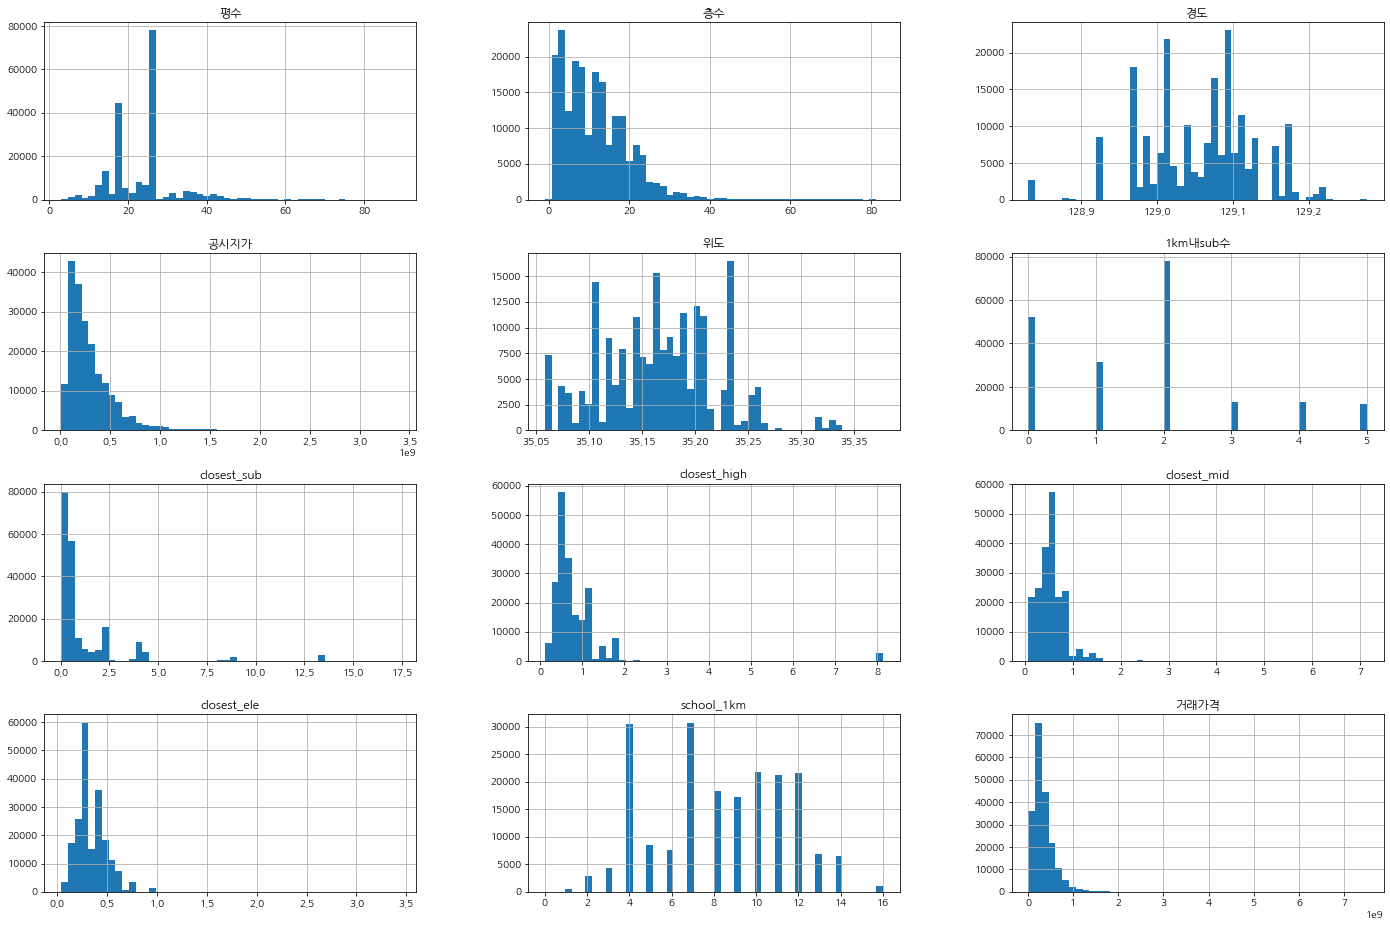

In [103]:
train_data.hist(bins=50, figsize=(24,16))
plt.rc('font', family='NanumGothic')

/home/subin/.local/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/usr/lib/python3/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


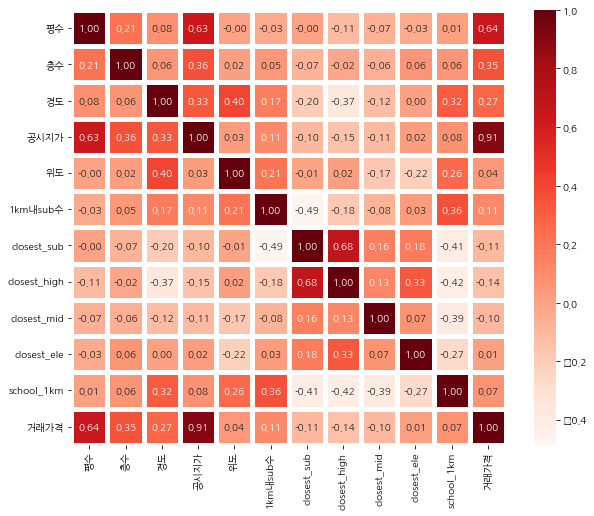

In [104]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(),annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds')

In [105]:
train_data['층수+'] = train_data['층수']+2
train_data['1km내sub수+'] = train_data['1km내sub수']+2
train_data['school_1km+'] = train_data['school_1km']+2
train_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

In [106]:
from scipy.stats import boxcox
train_data[['1km내sub수+', '평수']] = train_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
train_data[['school_1km+']] = np.sqrt(train_data[['school_1km+']])
train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(train_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

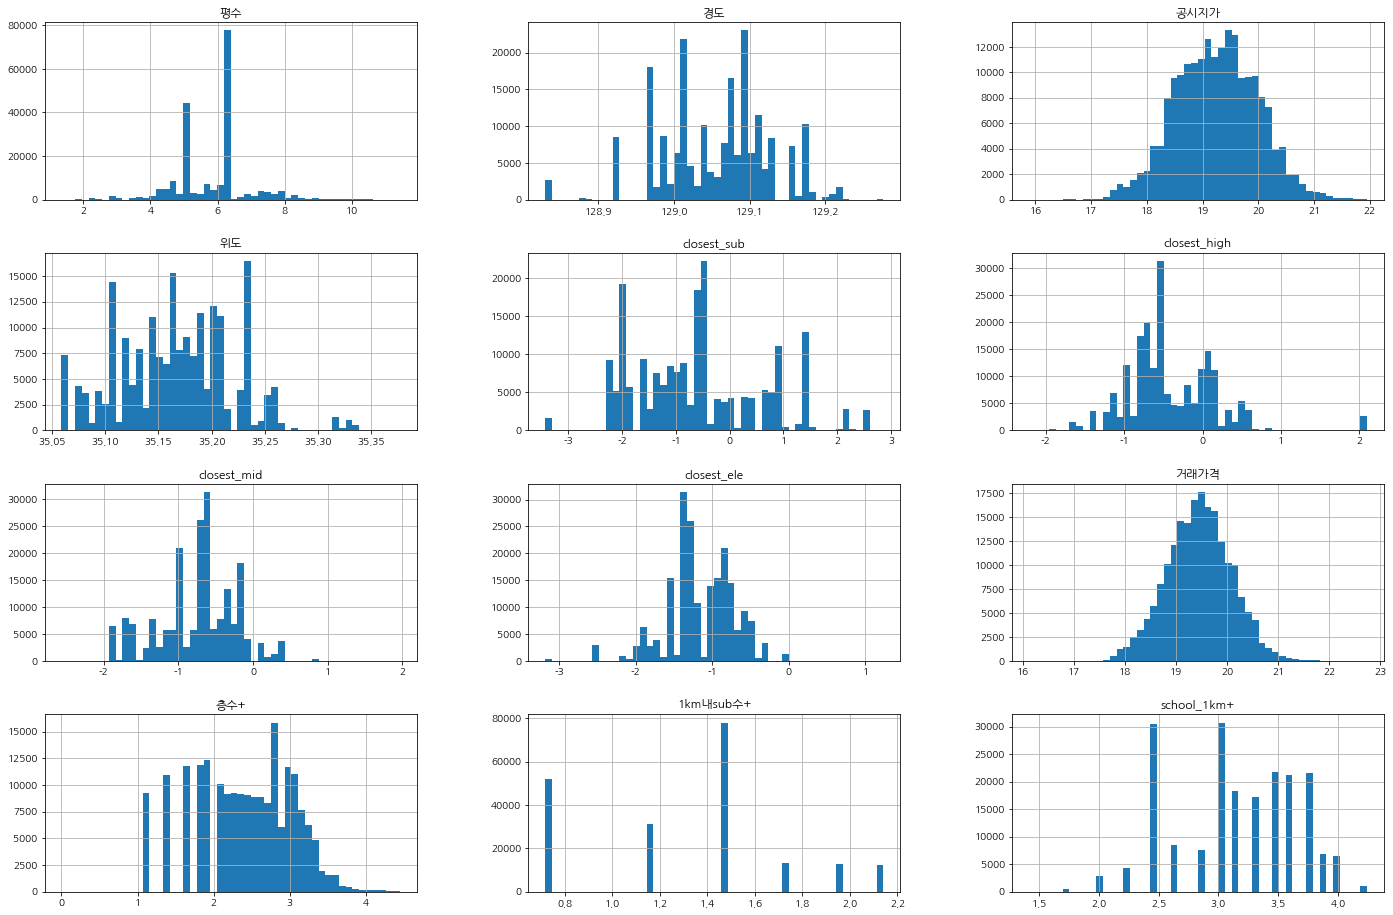

In [107]:
train_data.hist(bins=50, figsize=(24, 16))
plt.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus = False)

<Axes: >

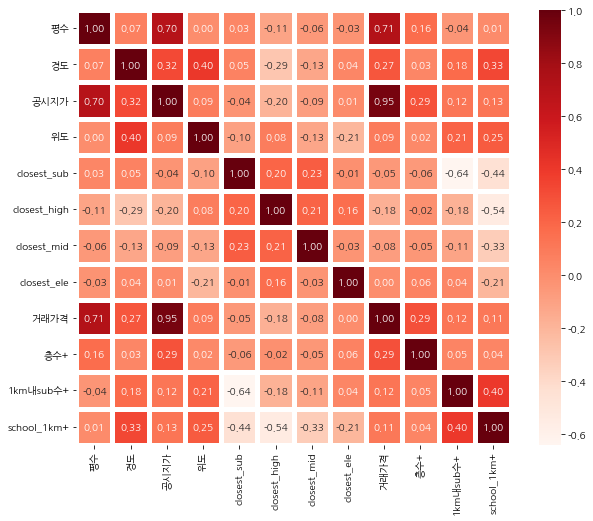

In [108]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(),annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds')

In [109]:
x_train, y_train = train_data.drop(['거래가격'], axis=1), train_data['거래가격']

In [110]:
valid_data = x_valid.join(y_valid)

valid_data['층수+'] = valid_data['층수']+2
valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
valid_data['school_1km+'] = valid_data['school_1km']+2
valid_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

from scipy.stats import boxcox
valid_data[['1km내sub수+', '평수']] = valid_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
valid_data[['school_1km+']] = np.sqrt(valid_data[['school_1km+']])
valid_data[['거래가격', '층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(valid_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

x_valid, y_valid = valid_data.drop(['거래가격'], axis=1), valid_data['거래가격']

In [111]:
test_data = X_test.join(y_test)

test_data['층수+'] = test_data['층수']+2
test_data['1km내sub수+'] = test_data['1km내sub수']+2
test_data['school_1km+'] = test_data['school_1km']+2
test_data.drop(['층수', '1km내sub수', 'school_1km'], axis=1, inplace=True)

from scipy.stats import boxcox
test_data[['1km내sub수+', '평수']] = test_data[['1km내sub수+', '평수']].apply(lambda x: boxcox(x)[0])
test_data[['school_1km+']] = np.sqrt(test_data[['school_1km+']])
test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(test_data[['거래가격','층수+', '공시지가', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

X_test, y_test = test_data.drop(['거래가격'], axis=1), test_data['거래가격']

In [112]:
scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_valid_s = scaler.transform(x_valid)
X_test_s = scaler.transform(X_test)

In [113]:
# 선형회귀모델
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

linear.fit(x_train_s, y_train)

linear.score(X_test_s, y_test)

0.9031924887470848

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [119]:
y_pred_li = linear.predict(x_train_s)

lin_r2 = r2_score(y_train, y_pred_li)
lin_mae = mean_absolute_error(y_train, y_pred_li)
print(lin_r2)
print(lin_mae)

0.9029701679783915
0.15385977524282438


In [120]:
y_pred_li = linear.predict(x_valid_s)
lin_r2 = r2_score(y_valid, y_pred_li)
lin_mae = mean_absolute_error(y_valid, y_pred_li)
print(lin_r2)
print(lin_mae)

0.903739392044099
0.1533992770105062


In [115]:
# 의사결정나무

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(x_train_s, y_train)

DecisionTreeRegressor()

In [116]:
tree.score(X_test_s, y_test)

0.8707867069455448

In [117]:
y_pred_tr = tree.predict(x_train_s)

tree_R2 = r2_score(y_train, y_pred_tr)
tree_mae = mean_absolute_error(y_train, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.954704982120452
0.08955161649212282


In [118]:
y_pred_tr = tree.predict(x_valid_s)

tree_R2 = r2_score(y_valid, y_pred_tr)
tree_mae = mean_absolute_error(y_valid, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9040634156974333
0.14057112395895846


In [121]:
# XGBoost 회귀

import xgboost

xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train_s, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [122]:
y_pred_xgb = xgb_model.predict(x_train_s)

xgb_R2 = r2_score(y_train, y_pred_xgb)
xgb_mae = mean_absolute_error(y_train, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9263253127175901
0.1312876114117659


In [123]:
y_pred_xgb = xgb_model.predict(x_valid_s)

xgb_R2 = r2_score(y_valid, y_pred_xgb)
xgb_mae = mean_absolute_error(y_valid, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.9232580808889003
0.13375574751558997


In [124]:
# k-fold 교차검증 선형회귀모델

def display_scores(model, scores):
    print('<<', model, '모델 평가 결과 >>')
    print('평균 RMSE: ', scores.mean())
    print('표준편차: ', scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linear, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores('선형회귀', lin_rmse_scores)

<< 선형회귀 모델 평가 결과 >>
평균 RMSE:  0.19621504088346192
표준편차:  0.002170908361397897


In [125]:
# k-fold 교차검증 의사결정나무
tree_scores = cross_val_score(tree, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores('의사결정나무', tree_rmse_scores)

<< 의사결정나무 모델 평가 결과 >>
평균 RMSE:  0.22652646501886536
표준편차:  0.0023873954727819087


In [126]:
# k-fold 교차검증 XGBoost
xgb_model_scores = cross_val_score(xgb_model, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
xgb_model_rmse_scores = np.sqrt(-xgb_model_scores)
display_scores('XGBoost', xgb_model_rmse_scores)

<< XGBoost 모델 평가 결과 >>
평균 RMSE:  0.1791485016875784
표준편차:  0.0017834288234182733


In [127]:
# 최종모델의 성능평가 선형회귀모델

#x_test_nor = scaler.transform(X_test)
final_pred_li = linear.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_li = mean_squared_error(y_test, final_pred_li)
final_rmse_li = np.sqrt(final_mse_li)
final_r2_li = r2_score(y_test, final_pred_li)

print('RMSE: ', final_rmse_li)
print('R2: ', final_r2_li)

RMSE:  0.19690399030529465
R2:  0.9031924887470848


In [128]:
# 최종모델의 성능평가 의사결정나무

#x_test_nor = scaler.transform(X_test)
final_pred_tree = tree.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_tree = mean_squared_error(y_test, final_pred_tree)
final_rmse_tree = np.sqrt(final_mse_tree)
final_r2_tree = r2_score(y_test, final_pred_tree)

print('RMSE: ', final_rmse_tree)
print('R2: ', final_r2_tree)

RMSE:  0.22748543045650413
R2:  0.8707867069455448


In [129]:
# 최종모델의 성능평가 XGBoost

#x_test_nor = scaler.transform(X_test)
final_pred_xgb_model = xgb_model.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_xgb_model = mean_squared_error(y_test, final_pred_xgb_model)
final_rmse_xgb_model = np.sqrt(final_mse_xgb_model)
final_r2_xgb_model = r2_score(y_test, final_pred_xgb_model)

print('RMSE: ', final_rmse_xgb_model)
print('R2: ', final_r2_xgb_model)

RMSE:  0.18318017819389146
R2:  0.9162167939559442


In [130]:
# 예측값과 실제값의 비교 - 시각화

pred_li = pd.DataFrame(final_pred_li, columns=['예측가격'])
actual_li = pd.DataFrame(y_test)
actual_li.reset_index(inplace=True, drop=True)
table_li = pd.concat([pred_li, actual_li], axis=1)

table_li['실제거래가격'] = np.exp(table_li['거래가격'])
table_li['실제예측가격'] = np.exp(table_li['예측가격'])
table_li['오차율'] = (table_li['거래가격'] - table_li['예측가격']) / table_li['거래가격'] * 100
table_li['실제오차율'] = (table_li['실제거래가격'] - table_li['실제예측가격']) / table_li['실제거래가격'] * 100
table_li.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,62291.000000,62291.000000,6.229100e+04,6.229100e+04,62291.000000,62291.000000
mean,19.439656,19.447690,3.413669e+08,3.313563e+08,0.030819,-1.150946
std,0.599627,0.632854,2.471368e+08,2.174273e+08,1.008810,20.414121
min,17.236226,16.118096,1.000000e+07,3.059130e+07,-7.160021,-217.103797
25%,19.006722,19.024997,1.830000e+08,1.796860e+08,-0.595482,-12.226900
50%,19.445061,19.450300,2.800000e+08,2.785368e+08,0.018480,0.358852
75%,19.865583,19.862883,4.230000e+08,4.241436e+08,0.688131,12.509979
max,21.655921,22.302245,4.850000e+09,2.541249e+09,6.559455,72.433507


Text(0.5, 1.0, '선형회귀분석 실제오차율 분포')

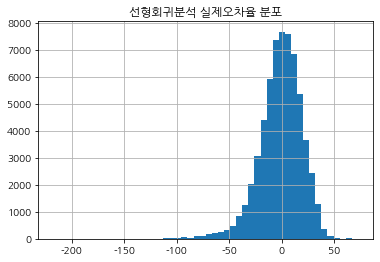

In [131]:
table_li['실제오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)
plt.title('선형회귀분석 실제오차율 분포')

<Axes: >

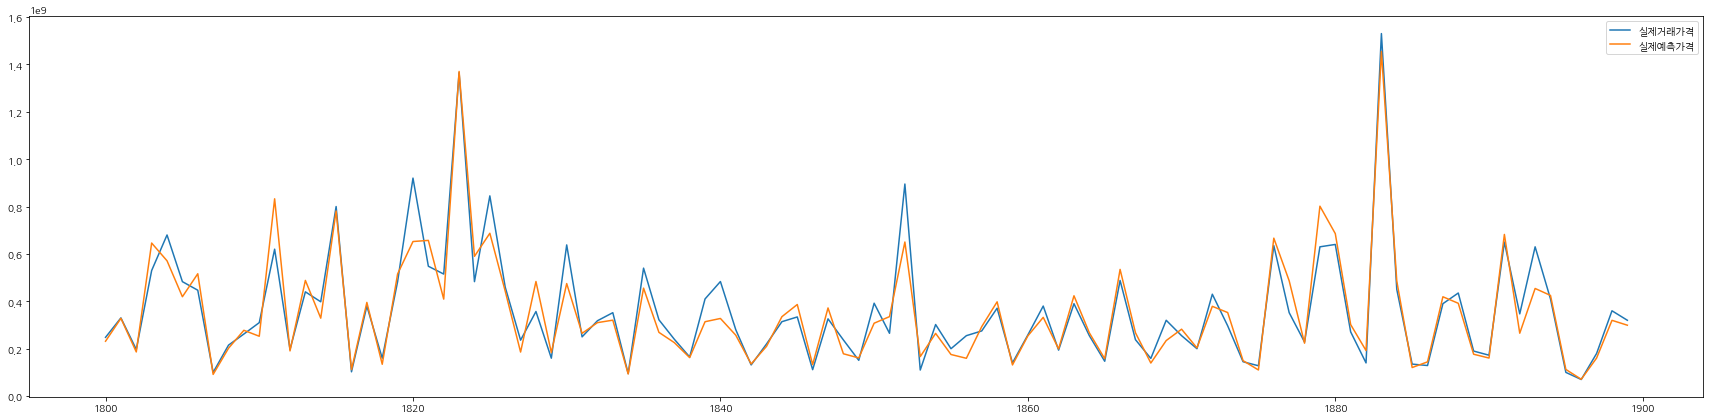

In [132]:
# 선형회귀분석 예측 정확도 시각화

real_li = table_li[['실제거래가격', '실제예측가격']]
plt.rc('font', family='NanumGothic')
real_li.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

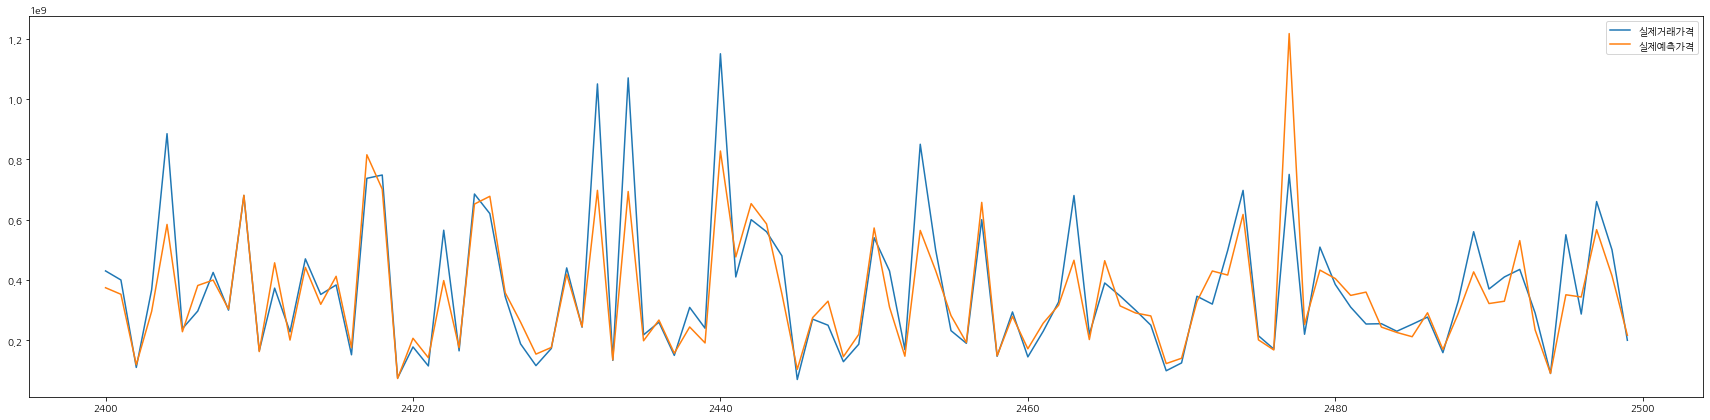

In [133]:
plt.rc('font', family='NanumGothic')
real_li.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

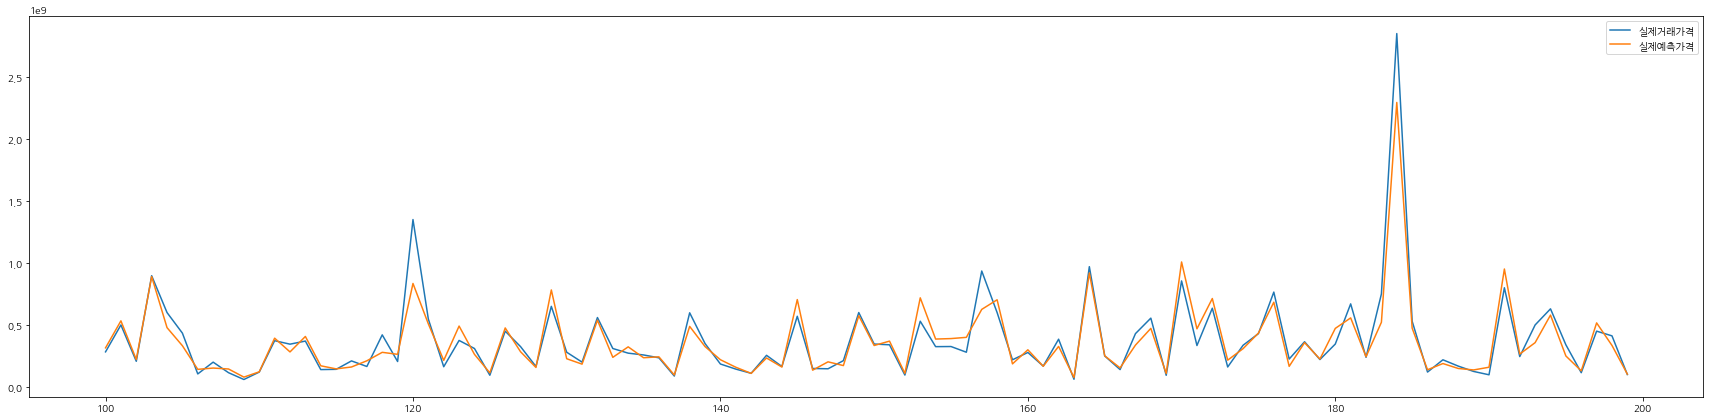

In [134]:
plt.rc('font', family='NanumGothic')
real_li.iloc[100:200, :].plot(figsize=(30,7))

In [135]:
error_li = table_li[(table_li['실제오차율']>=10)|(table_li['실제오차율']<=-10)]
error_li_only = error_li[['실제거래가격', '실제예측가격']]
error_li.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,36546.000000,36546.000000,3.654600e+04,3.654600e+04,36546.000000,36546.000000
mean,19.496901,19.508614,3.677064e+08,3.509076e+08,0.042293,-2.045481
std,0.602051,0.658435,2.743456e+08,2.292458e+08,1.293512,26.184670
min,17.236226,16.118096,1.000000e+07,3.059130e+07,-7.160021,-217.103797
25%,19.074035,19.103778,1.980000e+08,1.921976e+08,-0.947782,-20.182555
50%,19.512559,19.519293,3.000000e+08,2.979866e+08,0.558364,10.294781
75%,19.923982,19.946737,4.600000e+08,4.496509e+08,1.067470,18.869195
max,21.655921,22.302245,4.850000e+09,2.541249e+09,6.559455,72.433507


<Axes: >

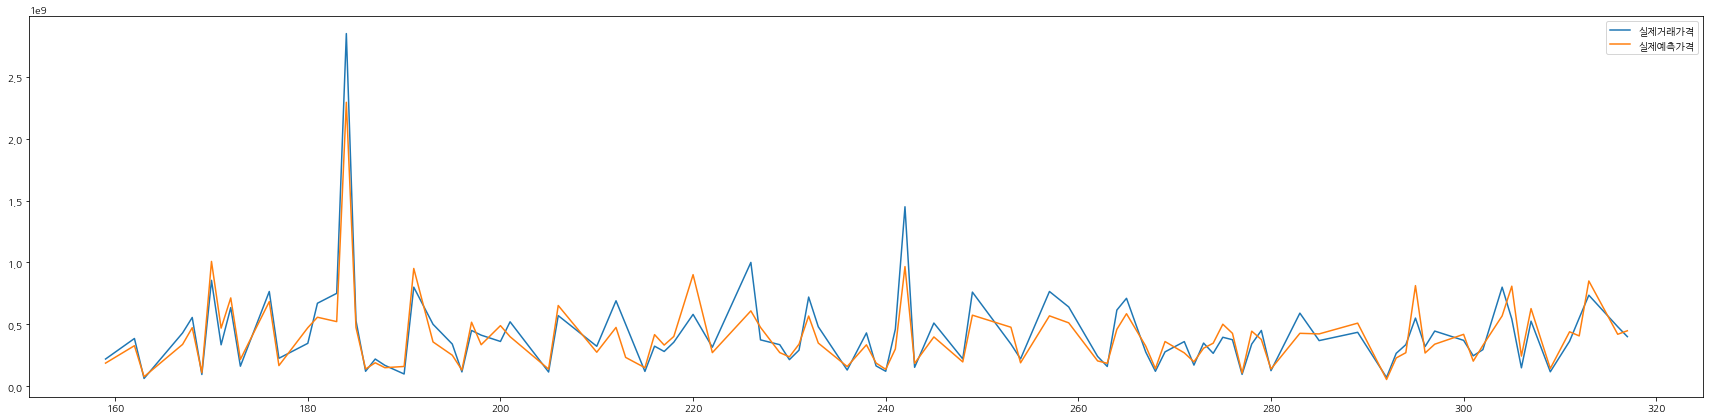

In [136]:
plt.rc('font', family='NanumGothic')
error_li_only.iloc[100:200, :].plot(figsize=(30,7))

In [137]:
# 예측값과 실제값의 비교 - 의사결정나무

pred_tree = pd.DataFrame(final_pred_tree, columns=['예측가격'])
actual_tree = pd.DataFrame(y_test)
actual_tree.reset_index(inplace=True, drop=True)
table_tree = pd.concat([pred_tree, actual_tree], axis=1)

table_tree['실제거래가격'] = np.exp(table_tree['거래가격'])
table_tree['실제예측가격'] = np.exp(table_tree['예측가격'])
table_tree['오차율'] = (table_tree['거래가격'] - table_tree['예측가격']) / table_tree['거래가격'] * 100
table_tree['실제오차율'] = (table_tree['실제거래가격'] - table_tree['실제예측가격']) / table_tree['실제거래가격'] * 100
table_tree.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,62291.000000,62291.000000,6.229100e+04,6.229100e+04,62291.000000,62291.000000
mean,19.438523,19.447690,3.413669e+08,3.375919e+08,0.040117,-1.648135
std,0.630983,0.632854,2.471368e+08,2.408741e+08,1.160635,23.388918
min,16.718477,16.118096,1.000000e+07,1.822814e+07,-7.562831,-308.333333
25%,19.008467,19.024997,1.830000e+08,1.800000e+08,-0.605972,-12.413793
50%,19.463268,19.450300,2.800000e+08,2.836547e+08,0.000000,0.000000
75%,19.853057,19.862883,4.230000e+08,4.188642e+08,0.637039,11.636364
max,22.302245,22.302245,4.850000e+09,4.850000e+09,9.569694,84.313725


Text(0.5, 1.0, '의사결정나무 실제오차율 분포')

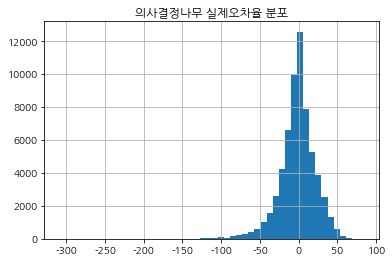

In [138]:
table_tree['실제오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)
plt.title('의사결정나무 실제오차율 분포')

<Axes: >

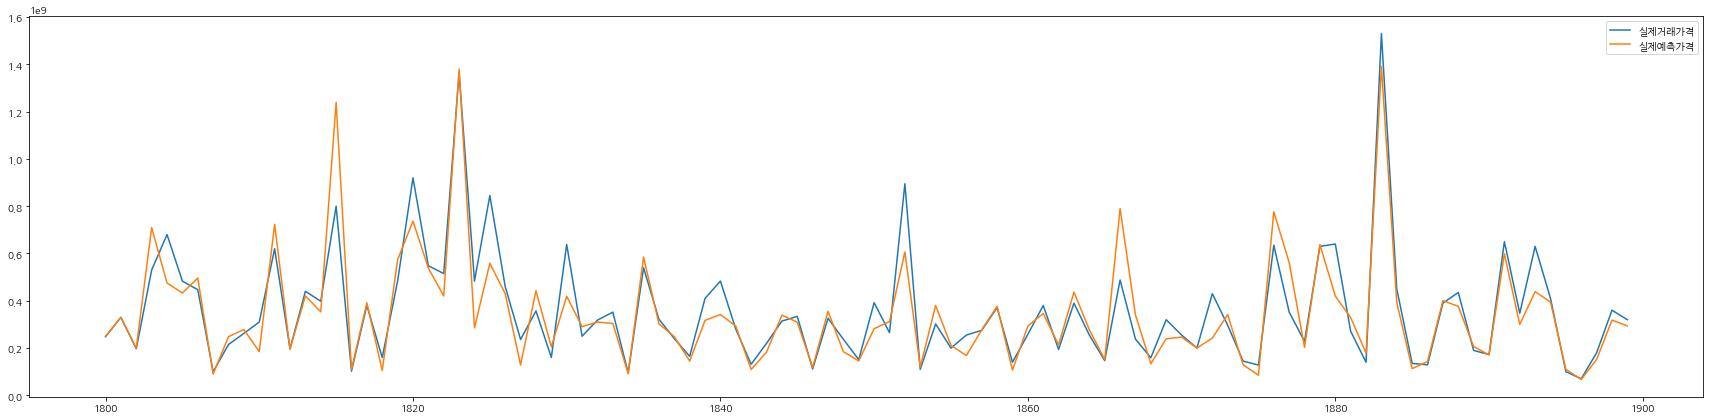

In [139]:
# 의사결정나무 예측 정확도 시각화

table_tree_only = table_tree[['실제거래가격', '실제예측가격']]
plt.rc('font', family='NanumGothic')
table_tree_only.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

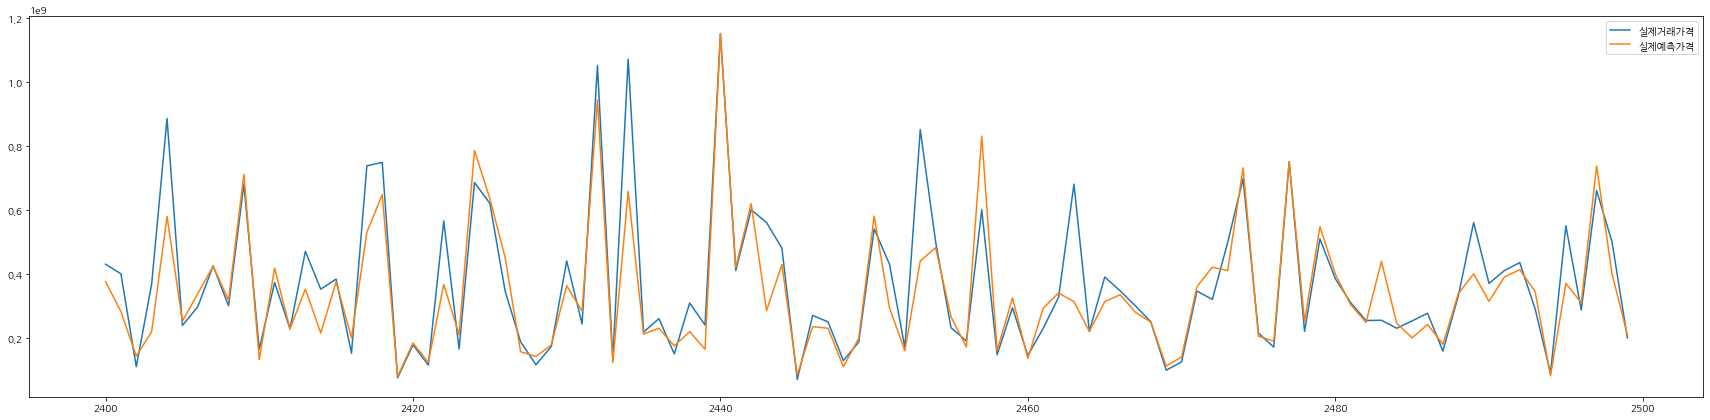

In [140]:
plt.rc('font', family='NanumGothic')
table_tree_only.iloc[2400:2500, :].plot(figsize=(30,7))

<Axes: >

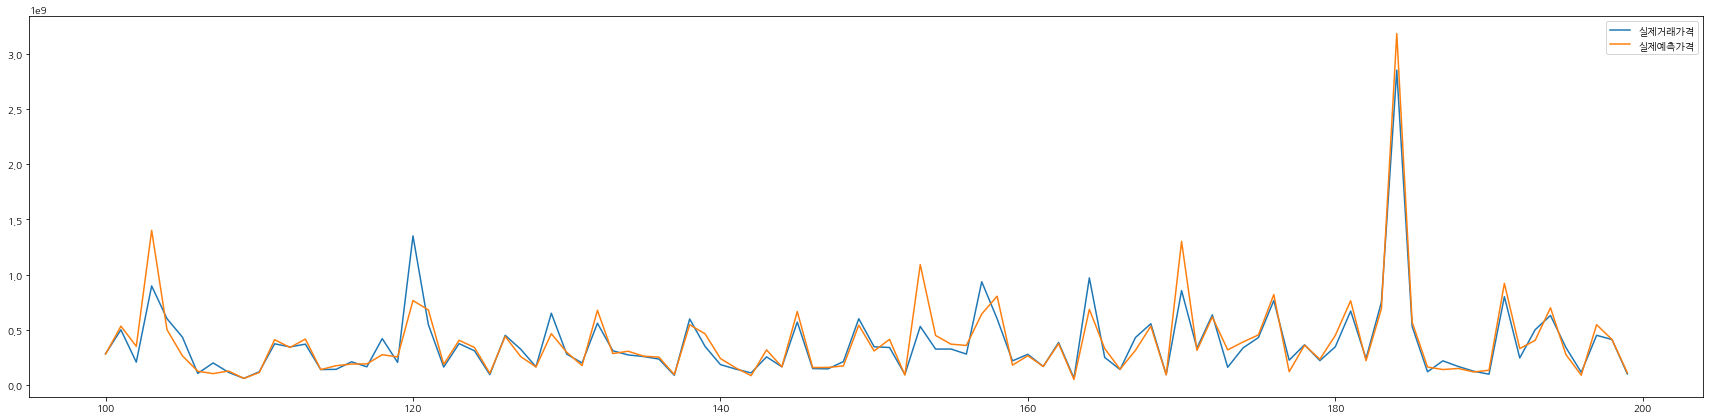

In [141]:
plt.rc('font', family='NanumGothic')
table_tree_only.iloc[100:200, :].plot(figsize=(30,7))

In [142]:
error_tree = table_tree[(table_tree['실제오차율']>=10)|(table_tree['실제오차율']<=-10)]
error_tree_only = error_tree[['실제거래가격', '실제예측가격']]
error_tree.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,35097.000000,35097.000000,3.509700e+04,3.509700e+04,35097.000000,35097.000000
mean,19.489242,19.505347,3.653213e+08,3.585841e+08,0.070519,-2.832408
std,0.648446,0.651064,2.678133e+08,2.582144e+08,1.526546,30.755758
min,16.718477,16.118096,1.000000e+07,1.822814e+07,-7.562831,-308.333333
25%,19.030446,19.062535,1.900000e+08,1.840000e+08,-1.035083,-22.126335
50%,19.515996,19.502486,2.950000e+08,2.990126e+08,-0.507544,-10.367128
75%,19.931512,19.953238,4.630000e+08,4.530497e+08,1.201013,20.952689
max,22.302245,22.227343,4.500000e+09,4.850000e+09,9.569694,84.313725


<Axes: >

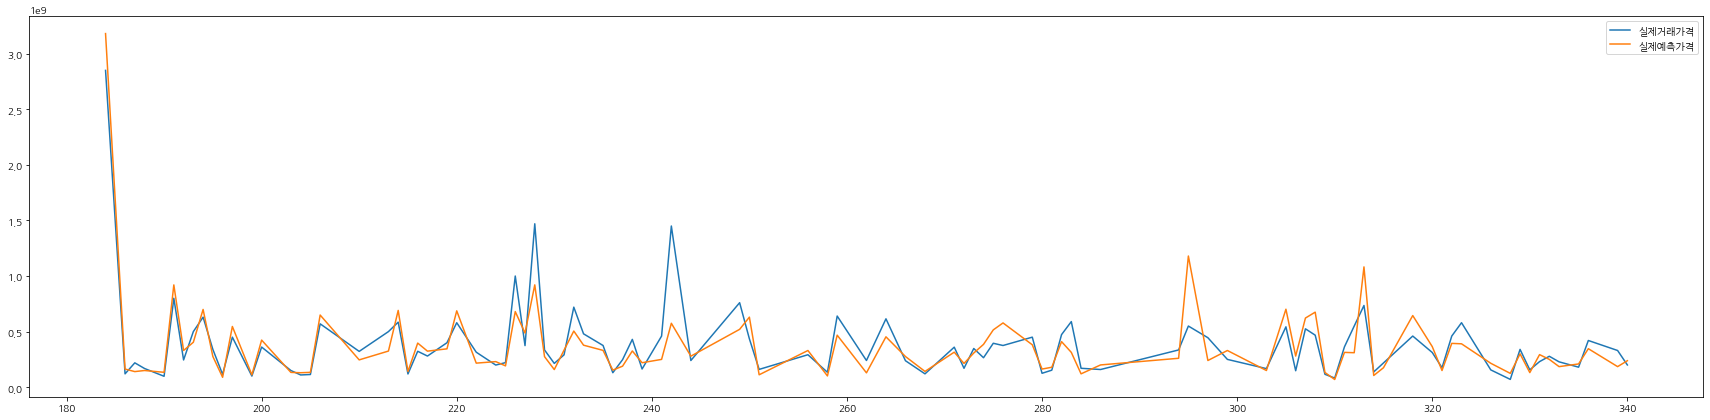

In [143]:
plt.rc('font', family='NanumGothic')
error_tree_only.iloc[100:200, :].plot(figsize=(30,7))

In [144]:
# 예측값과 실제값의 비교 - 시각화

pred_xgb_model = pd.DataFrame(final_pred_xgb_model, columns=['예측가격'])
actual_xgb_model = pd.DataFrame(y_test)
actual_xgb_model.reset_index(inplace=True, drop=True)
table_xgb_model = pd.concat([pred_xgb_model, actual_xgb_model], axis=1)

table_xgb_model['실제거래가격'] = np.exp(table_xgb_model['거래가격'])
table_xgb_model['실제예측가격'] = np.exp(table_xgb_model['예측가격'])
table_xgb_model['오차율'] = (table_xgb_model['거래가격'] - table_xgb_model['예측가격']) / table_xgb_model['거래가격'] * 100
table_xgb_model['실제오차율'] = (table_xgb_model['실제거래가격'] - table_xgb_model['실제예측가격']) / table_xgb_model['실제거래가격'] * 100
table_xgb_model.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,62291.000000,62291.000000,6.229100e+04,6.229100e+04,62291.000000,62291.000000
mean,19.430622,19.447690,3.413669e+08,3.310706e+08,0.080413,0.069265
std,0.614051,0.632854,2.471368e+08,2.231731e+08,0.930634,18.044647
min,16.786354,16.118096,1.000000e+07,1.950837e+07,-5.611824,-178.602560
25%,19.016672,19.024997,1.830000e+08,1.814829e+08,-0.505796,-10.271225
50%,19.442026,19.450300,2.800000e+08,2.776928e+08,0.020354,0.390899
75%,19.838747,19.862883,4.230000e+08,4.129128e+08,0.617821,11.288335
max,22.008371,22.302245,4.850000e+09,3.615049e+09,5.856199,68.177892


Text(0.5, 1.0, 'XGBoost 실제오차율 분포')

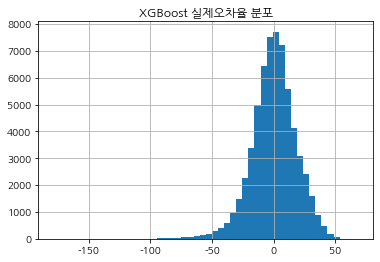

In [145]:
table_xgb_model['실제오차율'].hist(bins=50)
plt.rc("axes", unicode_minus = False)
plt.title('XGBoost 실제오차율 분포')

<Axes: >

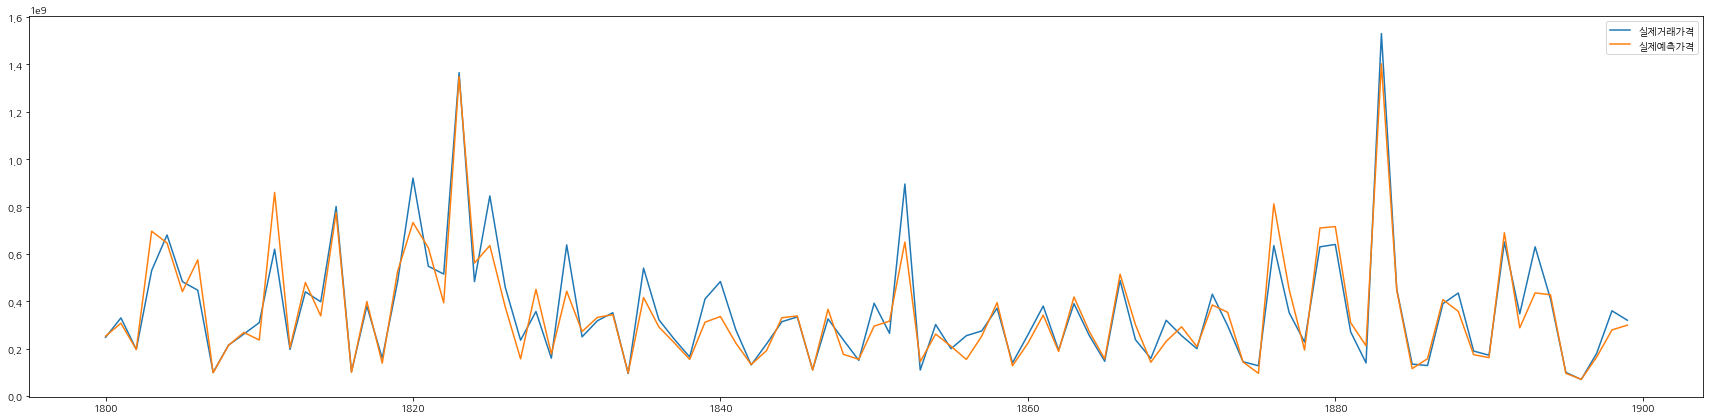

In [146]:
# 선형회귀분석 예측 정확도 시각화

real_xgb_model = table_xgb_model[['실제거래가격', '실제예측가격']]
plt.rc('font', family='NanumGothic')
real_xgb_model.iloc[1800:1900, :].plot(figsize=(30,7))

In [147]:
error_xgb_model = table_xgb_model[(table_xgb_model['실제오차율']>=10)|(table_xgb_model['실제오차율']<=-10)]
error_xgb_model_only = error_xgb_model[['실제거래가격', '실제예측가격']]
error_xgb_model.describe()

,예측가격,거래가격,실제거래가격,실제예측가격,오차율,실제오차율
count,33004.000000,33004.000000,3.300400e+04,3.300400e+04,33004.000000,33004.000000
mean,19.501390,19.531712,3.753118e+08,3.557132e+08,0.141687,0.079874
std,0.620262,0.655520,2.763060e+08,2.366639e+08,1.246030,24.228084
min,16.786354,16.118096,1.000000e+07,1.950837e+07,-5.611824,-178.602560
25%,19.080475,19.108815,1.990000e+08,1.934394e+08,-0.858147,-18.113240
50%,19.535809,19.535822,3.050000e+08,3.049958e+08,0.571388,10.483380
75%,19.916369,19.989297,4.800000e+08,4.462407e+08,1.107596,19.474364
max,22.008371,22.302245,4.850000e+09,3.615049e+09,5.856199,68.177892


<Axes: >

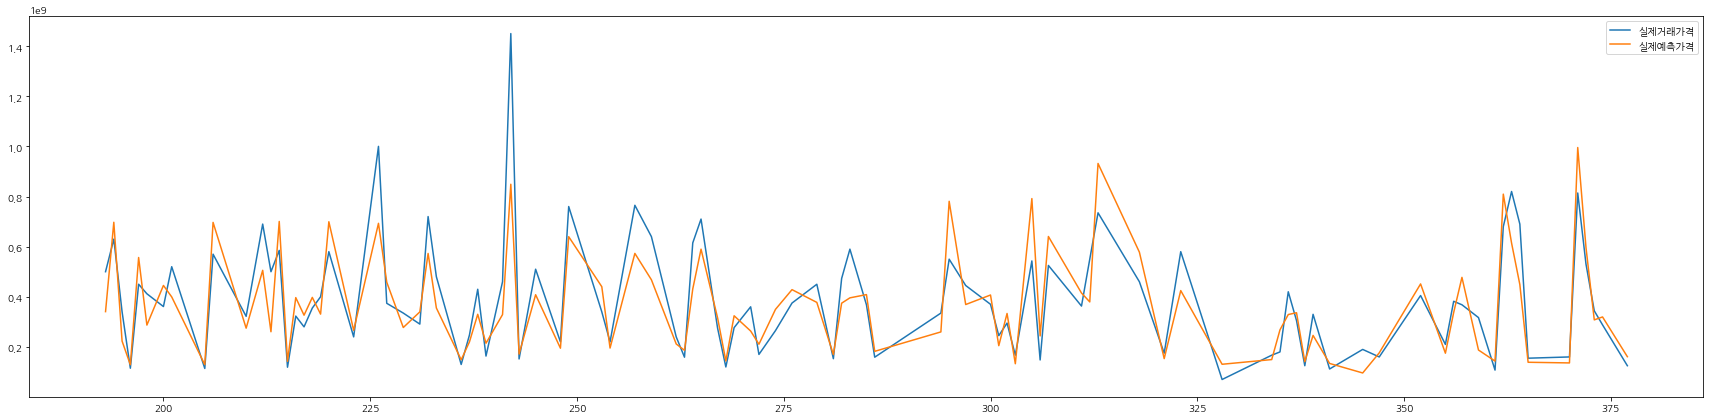

In [148]:
plt.rc('font', family='NanumGothic')
error_xgb_model_only.iloc[100:200, :].plot(figsize=(30,7))